# 2. Estimating Underperformance

## 1. Summary Statistics

In [1]:
import pandas as pd
import numpy as np

data = pd.read_excel("barnstable_analysis_data.xlsx", sheet_name="data")
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['Year'] = data['date'].dt.year

END_YR = 2024

samples = {
    "1965-1999": data[(data['Year'] >= 1965) & (data['Year'] <= 1999)],
    "2000-2024": data[(data['Year'] >= 2000) & (data['Year'] <= END_YR)],
    "1926-2024": data[(data['Year'] >= 1926) & (data['Year'] <= END_YR)]
}

In [2]:
data

,date,SPX,TB1M,Year
0,1926-01-30,-0.001783,0.003061,1926
1,1926-02-27,-0.033297,0.002612,1926
2,1926-03-31,-0.057708,0.002601,1926
3,1926-04-30,0.038522,0.002270,1926
4,1926-05-28,0.013623,0.002691,1926
...,...,...,...,...
1183,2024-08-30,0.024283,0.004380,2024
1184,2024-09-30,0.022821,0.003826,2024
1185,2024-10-31,-0.008690,0.003752,2024
1186,2024-11-29,0.060420,0.003475,2024


In [3]:
def summary_stats(df, freq='M'):
    r_m = df['SPX']           
    r_f = df['TB1M']          
    log_r_m = np.log1p(r_m)  
    log_r_f = np.log1p(r_f)
    
    if freq == 'M':
        ann_factor = 12
    elif freq == 'D':
        ann_factor = 252
    else:
        ann_factor = 1
    
    # -------- Levels ----------
    r_m_mean = r_m.mean() * ann_factor
    r_m_vol = r_m.std() * np.sqrt(ann_factor)
    
    r_f_mean = r_f.mean() * ann_factor
    r_f_vol = r_f.std() * np.sqrt(ann_factor)
    
    # -------- Level (tilde r^m) ----------
    tilde_r_m_mean = (np.prod(1+r_m))**(ann_factor/len(r_m)) - 1    # tilde r^m: interest rate
    tilde_r_m_vol = np.expm1(log_r_m.std() * np.sqrt(ann_factor))
    
    # -------- Log ----------
    log_r_m_mean = log_r_m.mean() * ann_factor
    log_r_m_vol = log_r_m.std() * np.sqrt(ann_factor)
    
    log_r_f_mean = log_r_f.mean() * ann_factor
    log_r_f_vol = log_r_f.std() * np.sqrt(ann_factor)
    
    # -------- Log (tilde r^m) ----------
    tilde_log_r_m_mean = np.log1p(tilde_r_m_mean)
    tilde_log_r_m_vol = tilde_r_m_vol 
    
    stats = {
        'r_m_mean': r_m_mean,
        'r_m_vol': r_m_vol,
        'tilde_r_m_mean': tilde_r_m_mean,
        'tilde_r_m_vol': tilde_r_m_vol,
        'r_f_mean': r_f_mean,
        'r_f_vol': r_f_vol,
        'log_r_m_mean': log_r_m_mean,
        'log_r_m_vol': log_r_m_vol,
        'tilde_log_r_m_mean': tilde_log_r_m_mean,
        'tilde_log_r_m_vol': tilde_log_r_m_vol,
        'log_r_f_mean': log_r_f_mean,
        'log_r_f_vol': log_r_f_vol
    }
    return stats

results = {}
for name, df in samples.items():
    results[name] = summary_stats(df)

md = "| | 1965-1999 | | | 2000-2024 | | | 1926-2024 | |\n"
md += "|---|---|---|---|---|---|---|---|---|\n"
md += "| | mean | vol | | mean | vol | | mean | vol |\n"

rows = {
    "r^m (level)": "r_m_mean",
    "tilde r^m (interest rate)": "tilde_r_m_mean",
    "r^f (level)": "r_f_mean",
    "log r^m": "log_r_m_mean",
    "tilde log r^m": "tilde_log_r_m_mean",
    "log r_f": "log_r_f_mean"
}

for label, key_mean in rows.items():
    md += f"| {label} "
    for sample in ["1965-1999","2000-2024","1926-2024"]:
        mean = results[sample][key_mean]
        vol_key = key_mean.replace("mean","vol")
        vol = results[sample][vol_key]
        md += f"| {mean:.4f} | {vol:.4f} "
    md += "|\n"

print(md)


| | 1965-1999 | | | 2000-2024 | | | 1926-2024 | |
|---|---|---|---|---|---|---|---|---|
| | mean | vol | | mean | vol | | mean | vol |
| r^m (level) | 0.1294 | 0.1494 | 0.0875 | 0.1528 | 0.1155 | 0.1866 |
| tilde r^m (interest rate) | 0.1248 | 0.1613 | 0.0785 | 0.1662 | 0.1028 | 0.2043 |
| r^f (level) | 0.0615 | 0.0072 | 0.0175 | 0.0056 | 0.0319 | 0.0085 |
| log r^m | 0.1176 | 0.1496 | 0.0756 | 0.1538 | 0.0978 | 0.1859 |
| tilde log r^m | 0.1176 | 0.1613 | 0.0756 | 0.1662 | 0.0978 | 0.2043 |
| log r_f | 0.0613 | 0.0071 | 0.0174 | 0.0055 | 0.0318 | 0.0085 |



## 2. Probability of Underperformance

### 2.1 Calculate the probability using the subsample 1965-1999.

In [5]:
from scipy.stats import norm

df = samples["1965-1999"]

log_r_m = np.log1p(df['SPX'])
log_r_f = np.log1p(df['TB1M'])

mean_m = log_r_m.mean()
mean_f = log_r_f.mean()
std_m = log_r_m.std()

SR = (mean_m - mean_f) / std_m

def underperformance_prob(h):
    return norm.cdf(-SR * np.sqrt(h))
SR

np.float64(0.10862268959084882)

### 2.2 Report the precise probability for h=15 and h=30 years.

In [32]:
for h in [15,30]:
    p = underperformance_prob(h)
    print(f"h={h} years: P(R^m < R^f) = {p:.4f}")

h=15 years: P(R^m < R^f) = 0.3370
h=30 years: P(R^m < R^f) = 0.2759


### 2.3 Plot the probability as a function of the investment horizon, h, for 0<h<=30 years.

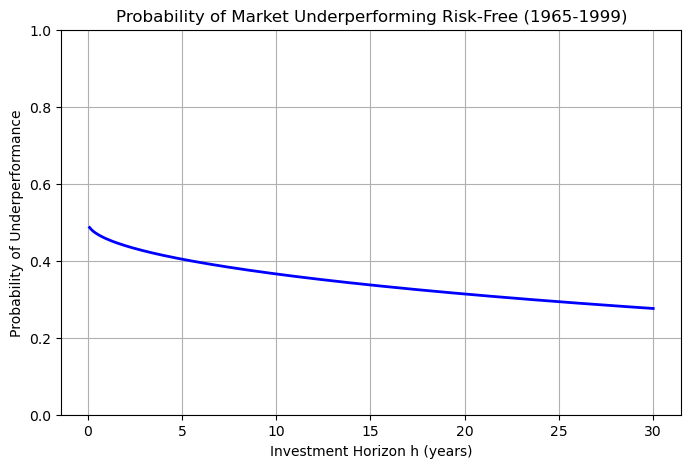

In [33]:
import matplotlib.pyplot as plt
import numpy as np

h_values = np.linspace(0.1, 30, 300)  # 可以平滑显示曲线
prob_values = [underperformance_prob(h) for h in h_values]

plt.figure(figsize=(8,5))
plt.plot(h_values, prob_values, color='blue', lw=2)
plt.xlabel("Investment Horizon h (years)")
plt.ylabel("Probability of Underperformance")
plt.title("Probability of Market Underperforming Risk-Free (1965-1999)")
plt.grid(True)
plt.ylim(0,1)
plt.show()

## 3. Full Sample Analysis

In [ ]:
df_full = data[(data['Year'] >= 1965) & (data['Year'] <= END_YR)]

log_r_m_full = np.log1p(df_full['SPX'])
log_r_f_full = np.log1p(df_full['TB1M'])

mean_m_full = log_r_m_full.mean()
mean_f_full = log_r_f_full.mean()
std_m_full = log_r_m_full.std()

SR_full = (mean_m_full - mean_f_full) / std_m_full

In [36]:
from scipy.stats import norm

def underperformance_prob_full(h):
    return norm.cdf(-SR_full * np.sqrt(h))

In [37]:
h_30 = 30
p_30_full = underperformance_prob_full(h_30)
print(f"Full sample (1965-{END_YR}) probability of underperforming over 30 years: {p_30_full:.4f}")

Full sample (1965-2024) probability of underperforming over 30 years: 0.2755


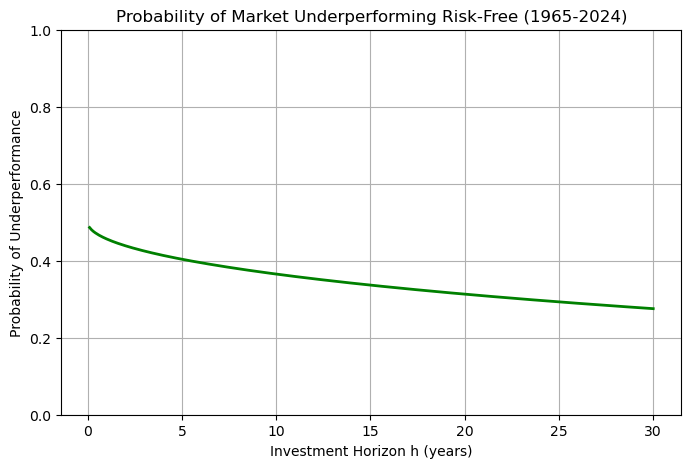

In [38]:
import matplotlib.pyplot as plt
h_values = np.linspace(0.1, 30, 300)
prob_values_full = [underperformance_prob_full(h) for h in h_values]

plt.figure(figsize=(8,5))
plt.plot(h_values, prob_values_full, color='green', lw=2)
plt.xlabel("Investment Horizon h (years)")
plt.ylabel("Probability of Underperformance")
plt.title(f"Probability of Market Underperforming Risk-Free (1965-{END_YR})")
plt.grid(True)
plt.ylim(0,1)
plt.show()

## 4. In-Sample Estimate of Out-of-Sample Likelihood

In [39]:
# In-sample: 1965-1999
df_in = samples["1965-1999"]
log_r_m_in = np.log1p(df_in['SPX'])
mean_in = log_r_m_in.mean()
std_in = log_r_m_in.std()

# Out-of-sample: 2000-2024
df_out = samples["2000-2024"]
log_r_m_out = np.log1p(df_out['SPX'])
mean_out = log_r_m_out.mean()

In [40]:
from scipy.stats import norm

def out_of_sample_prob(h):
    """Probability that cumulative h-year return falls below out-of-sample realized mean"""
    z = np.sqrt(h) * (mean_out - mean_in) / std_in
    return norm.cdf(z)

In [41]:
for h in [1,5,10,15,30]:
    p = out_of_sample_prob(h)
    print(f"h={h} years: P(R^m < R^m_out-of-sample) = {p:.4f}")

h=1 years: P(R^m < R^m_out-of-sample) = 0.4677
h=5 years: P(R^m < R^m_out-of-sample) = 0.4280
h=10 years: P(R^m < R^m_out-of-sample) = 0.3987
h=15 years: P(R^m < R^m_out-of-sample) = 0.3766
h=30 years: P(R^m < R^m_out-of-sample) = 0.3283


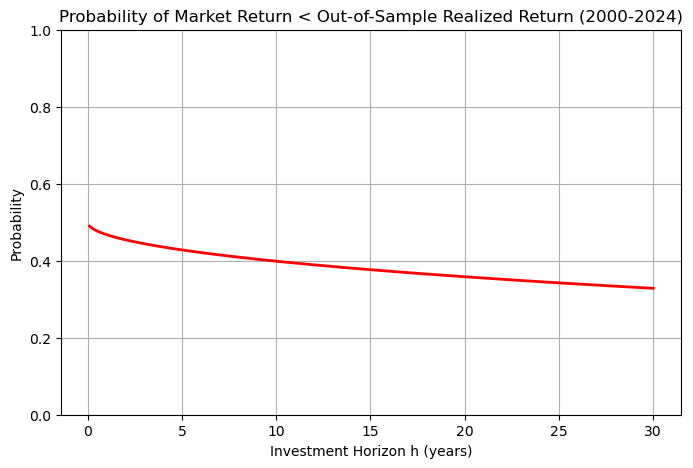

In [42]:
import matplotlib.pyplot as plt
h_values = np.linspace(0.1,30,300)
prob_values_oos = [out_of_sample_prob(h) for h in h_values]

plt.figure(figsize=(8,5))
plt.plot(h_values, prob_values_oos, color='red', lw=2)
plt.xlabel("Investment Horizon h (years)")
plt.ylabel("Probability")
plt.title("Probability of Market Return < Out-of-Sample Realized Return (2000-2024)")
plt.grid(True)
plt.ylim(0,1)
plt.show()